### based on https://github.com/higgsfield/RL-Adventure

In [1]:
%matplotlib inline
import collections
import gym
import matplotlib.pyplot as plot
import numpy as np
import random
import time
import torch as t
from IPython.display import clear_output
t.multiprocessing.set_start_method("spawn")

In [2]:
env = gym.make('CartPole-v1')

In [3]:
class Replay(object):
    def __init__(self, maxlen=1000):
        self.buffer = collections.deque(maxlen=maxlen)
    def add(self, state, action, next_state, reward, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, next_state, reward, done))
    def sample(self, n):
        state, action, next_state, reward, done = zip(*random.sample(self.buffer, n))
        state = np.concatenate(state, axis=0)
        next_state = np.concatenate(next_state, axis=0)
        reward = np.array(reward)
        done = np.array(done)
        
        state = t.FloatTensor(state).to(device)
        action = t.LongTensor(action).to(device)
        next_state = t.FloatTensor(next_state).to(device)
        reward = t.FloatTensor(reward).to(device)
        done = t.FloatTensor(done).to(device)
        
        return state, action, next_state, reward, done
    def __len__(self):
        return len(self.buffer)

In [4]:
USE_CUDA = t.cuda.is_available()# and False
device = t.device('cuda') if USE_CUDA else t.device('cpu')

In [5]:
def plot_state(msg):
    clear_output(False)
    print(msg)
    plot.figure(figsize=(24,5))
    plot.title(msg)
    plot.subplot(131)
    plot.title('rewards (frame=%dk, %d episodes)' % (np.round(frame/1000), episode))
    plot.plot(np.array(all_rewards)[:-1])
    plot.subplot(132)
    plot.title('losses')
    plot.plot(losses)
    plot.subplot(133)
    plot.title('control_values')
    plot.plot(control_values)
    plot.show();

finished


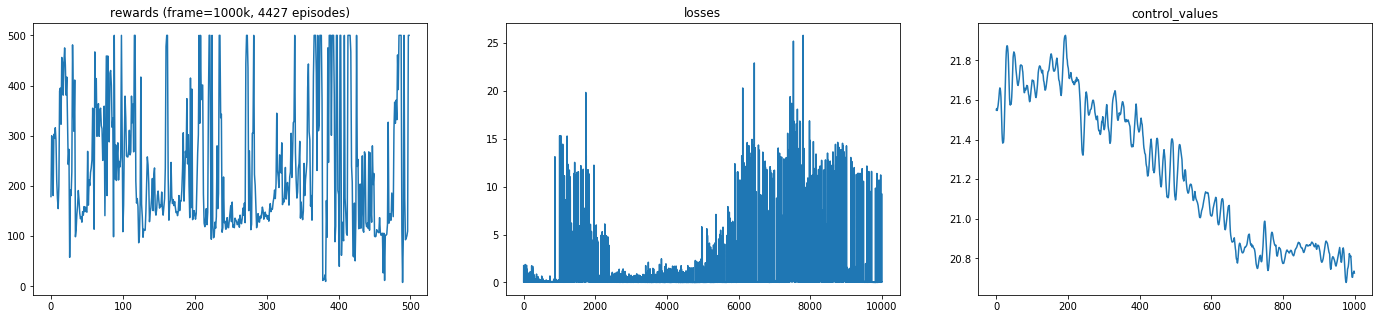

In [6]:
from cartpole_dqn_pytorch_play import play, build_model

def learn_on_replay():
    states, actions, next_states, rewards, masks = replay.sample(batch_size)
    
    q_values = model(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    q_next_value = target_model(next_states).max(1).values

    target = rewards + gamma * (1 - masks) * q_next_value
    loss = loss_fn(q_value, target.detach())

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

#if '__main__' == __name__:
DOUBLE_MODEL = True
model = build_model(env, device, 64)
target_model = build_model(env, device, 64) if DOUBLE_MODEL else model
opt = t.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = t.nn.MSELoss()#SmoothL1Loss()
model.share_memory()

replay = Replay(1000)
batch_size = 32
gamma = 0.95

queue = t.multiprocessing.Queue(maxsize=batch_size * 2)
player = t.multiprocessing.Process(target=play, args=(env, model, int(1e6), 0.01, 10000, queue))

losses = collections.deque(maxlen=10000)
player.start()
frame = 0
all_rewards = collections.deque([0], maxlen=500)
control_values = collections.deque(maxlen=1000)
episode = 1
finished = 'finished'
while True:
    exp = queue.get(timeout=5)
    if exp is None:
        break

    frame += 1
    state, action, next_state, reward, done, x = exp
    replay.add(state, action, next_state, reward, done)
    all_rewards[-1] += reward
    control_values.append(x)

    if done:
        episode += 1
        all_rewards.append(0)

    if len(replay) > batch_size:
        learn_on_replay()

    if DOUBLE_MODEL and frame % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    if frame % 1000 == 0:
        plot_state('')
    
    if len(all_rewards) > 100 and np.mean(np.array(all_rewards)[-100:]) >= 495:
        finished = 'solved'
        break

player.join()

plot_state(finished)